# Test Set Evaluation (2-Head Model)

Comprehensive evaluation notebook for the StepMania difficulty classifier with dual-head architecture.

**Features:**
- Load trained 2-head model and test data
- Evaluate both difficulty and source (community vs official) predictions
- Visualize random batch predictions
- Full test epoch with all metrics for both tasks
- Confusion matrices and per-class analysis for both heads
- Error analysis and confidence distribution
- Sample-level inspection

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import yaml

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Difficulty name classes
DIFFICULTY_NAMES = ['Beginner', 'Easy', 'Medium', 'Hard']
NUM_CLASSES = len(DIFFICULTY_NAMES)

# Source classes for 2-head model
SOURCE_NAMES = ['community', 'official']
NUM_SOURCES = len(SOURCE_NAMES)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Configuration

Set paths to checkpoint and data directories.

In [2]:
# === CONFIGURE THESE PATHS ===

# Checkpoint to evaluate
CHECKPOINT_DIR = Path('../models/classifier/classifier_2head')
CHECKPOINT_NAME = 'best_val_loss.pt'  # or 'last.pt'

# Data paths - update these to your test data location
DATA_DIR = Path('../data')  # Parent directory containing chart folders
TEST_SPLIT_RATIO = 0.15  # Fraction of data to use as test set

# Model config
CONFIG_PATH = Path('../config/model_config.yaml')

# Batch size for evaluation
BATCH_SIZE = 256

print(f"Checkpoint: {CHECKPOINT_DIR / CHECKPOINT_NAME}")
print(f"Config: {CONFIG_PATH}")

Checkpoint: ../models/classifier/classifier_2head/best_val_loss.pt
Config: ../config/model_config.yaml


## 2. Load Model

In [3]:
from src.models.classifier import LateFusionClassifier

# Load config
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

classifier_config = config['classifier']
print("Model config:")
print(f"  audio_features_dim: {classifier_config['audio_features_dim']}")
print(f"  num_classes: {classifier_config['num_classes']}")
print(f"  use_chart_stats: {classifier_config.get('use_chart_stats', False)}")

# Create model
model = LateFusionClassifier(classifier_config)
model = model.to(device)

# Load checkpoint
checkpoint_path = CHECKPOINT_DIR / CHECKPOINT_NAME
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
model.eval()

print(f"\nLoaded checkpoint from epoch {checkpoint.get('epoch', 'N/A')}")
print(f"Best val loss: {checkpoint.get('best_val_loss', 'N/A'):.4f}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Model config:
  audio_features_dim: 23
  num_classes: 4
  use_chart_stats: True

Loaded checkpoint from epoch 15
Best val loss: 0.4039
Total parameters: 2,767,878


## 3. Load Test Data

Load the test dataset. Uses the same data loading as training but with a held-out test split.

In [4]:
from src.data.dataset import StepManiaDataset
from torch.utils.data import DataLoader, random_split
import glob

# Find all chart files
chart_patterns = ['**/*.sm', '**/*.ssc']
chart_files = []
for pattern in chart_patterns:
    chart_files.extend(glob.glob(str(DATA_DIR / pattern), recursive=True))

print(f"Found {len(chart_files)} chart files")

# Create dataset
max_seq_len = classifier_config.get('max_sequence_length', 1440)
full_dataset = StepManiaDataset(
    chart_files=chart_files,
    audio_dir=str(DATA_DIR),
    max_sequence_length=max_seq_len
)

# Split into train/val/test
total_samples = len(full_dataset)
test_size = int(total_samples * TEST_SPLIT_RATIO)
val_size = int(total_samples * 0.15)
train_size = total_samples - test_size - val_size

# Use fixed seed for reproducible splits
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=generator
)

print(f"\nDataset splits:")
print(f"  Train: {len(train_dataset)}")
print(f"  Val: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")

# Create test loader
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"\nTest loader: {len(test_loader)} batches")

Found 7137 chart files
Parsing 7137 chart files...
Crow's Ghost failed song length requirement
cyanine failed song length requirement
Garyou Tensei failed song length requirement
iLLness LiLin failed bpm requirement
HELIX failed song length requirement
invoker failed song length requirement
Memory of Beach failed song length requirement
Haru Modoki (Asterisk DnB Remix) failed song length requirement
Tell Your World failed song length requirement
Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/! Haru Modoki (PnX)/Normal & Hard & Insane & Replica.sm: Variable BPM not supported in Phase 1
Meaning failed song length requirement
Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/! Claiomh Solais (-SoraGami- & AlisceaSparku)/4K Easy & 4K Normal & Aliscea's 4K Hard & 4K Insane.sm: Variable BPM not supported in Phase 1
Blastix Riotz failed bpm requirement
Chirality failed bpm requirement
Anemoi failed song length requirement
Sheriruth failed s

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 153.
Note: Trying to resync...
Note: Skipped 626 bytes in input.


Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/Din Don Dan (victorica_db)/4K Normal & 4K Hard & 4K Insane.sm: Audio file not found: ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/Din Don Dan (victorica_db)/Ryu feat.Mayumi Morinaga - Din Don Dan.MP3
Mobbyca failed song length requirement
Dotabata Animation failed bpm requirement
Dement ~After Legend~ failed bpm requirement
cyanine failed song length requirement
STARRING STAR failed song length requirement
Fading Star (Banshi Remix) failed song length requirement
Yeah! Break! Care! Break! (TV Size) failed song length requirement
WHITEOUT failed song length requirement
Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/! BRYNHILDR IN THE DARKNESS -Version EJECTED- (NaxelCL & [Shana Lesus] & vocaloid1anime2)/Shana's 4K NM & 4K HD & V1A2's 4K MX.sm: Variable BPM not supported in Phase 1
violet flow failed song length requirement
Harumachi Clover (TV Size) failed song length requ

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Daiuchuu Stage failed bpm requirement
Lesson by DJ failed song length requirement
Harlem Shake failed song length requirement
REANIMATE failed song length requirement
Doutei Korose failed song length requirement
ETERNAL DRAIN failed song length requirement
BEAUTIFUL WORLD failed song length requirement
Dement ~After Legend~ failed bpm requirement
Mermaid girl -Akiba Koubou MIX- failed song length requirement
Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/! Utakata, Ai no Mahoroba (Kyousuke- & ExUsagi & Abyssus- & diicky)/Usagi's 4K EZ & 4K NM & Abyssus' 4K HD & diicky's 4K MX.sm: Variable BPM not supported in Phase 1
Little Lion Man failed bpm requirement
Indigo Bird failed song length requirement
Sunshine failed song length requirement
The Shortest Mashcore Ever failed bpm requirement
XY&Z failed bpm requirement
HEKIREKI (TV Size) failed song length requirement
Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/! The Starry true (Fee

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/! BRYNHILDR IN THE DARKNESS -Version EJECTED- (error_exe777)/EZ & NM & HD.sm: Variable BPM not supported in Phase 1
Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/! Chemical Interference (Surono)/Dead Inside.sm: Variable BPM not supported in Phase 1
Owari to Hajimari no Oto failed bpm requirement
Tsuki -Yue- failed song length requirement
Lantinid failed bpm requirement
Yuuki no Pendant failed bpm requirement
Crystalia failed bpm requirement
NEO TREASON failed song length requirement
Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/! Tokyo Teddy Bear (puxtu) +/MX & SC & SHD.sm: Variable BPM not supported in Phase 1
Senritsu no Kodou failed bpm requirement
Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/! Figue Folle (Abraxos)/Abrax's Innocuous [Lv.3].sm: Variable BPM not supported in Phase 1
Error processing ../data/quarantine/O!M R

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Illusion of Inflict failed song length requirement
Tenkuu no Yoake failed song length requirement
Prismatic Lollipops failed bpm requirement
STARRING STAR failed song length requirement
CUSTOM DRIVE failed song length requirement
Jounetsu Utopia failed song length requirement
Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/! Stay Alive (Dellvangel)/Easy & Normal & Hard.sm: Variable BPM not supported in Phase 1
Myosotis failed song length requirement
Star Vs The Forces Of Evil Theme failed song length requirement
Kaga Misaki failed song length requirement
Oriental Shade failed song length requirement
A Match Into Water failed song length requirement
BLUE DRAGON failed song length requirement
Sheriruth failed song length requirement
220 - Kumano failed song length requirement
DON'T CUT failed song length requirement
ELPIS failed song length requirement
Scattered Rose failed song length requirement
Granat failed song length requirement
Isuzu no TRACK (speed up v

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


werewolf howls. failed bpm requirement
Couple Breaking failed song length requirement
Kyouran Hey Kids!! failed bpm requirement
Speedcore 300 failed bpm requirement
2 MINUTES FIGHTERS failed bpm requirement
Jounetsu Utopia failed song length requirement
fuego (sakuraburst remix) failed song length requirement
Shinobi failed song length requirement
Next Stop. With You failed song length requirement
KAC 2012 ULTIMATE MEDLEY -HISTORIA SOUND VOLTEX- failed song length requirement
STARRING STAR failed song length requirement
Kac (TV Size) failed song length requirement
Conveyor Sokudo Max!? Shainin*Kaiten Zushi "Sushi & Peace" failed bpm requirement
Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/! Mikasa (puxtu)/puxtu's HD & puxtu's MX.sm: Variable BPM not supported in Phase 1
Insane Techniques failed song length requirement
seal the 3rd.mp4 failed song length requirement
Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/! Black Emperor (

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Yeah! Break! Care! Break! (TV Size) failed song length requirement
Anemoi failed song length requirement
over the top failed bpm requirement
Alone failed song length requirement
The Empress (scream off ver.) failed bpm requirement
Hari no Sora failed song length requirement
Dreadnought failed song length requirement
Texas Is Forever failed bpm requirement
Plan 8 failed bpm requirement
Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/! Kakushinteki Metamaruphose! (Crystal & victorica_db)/Lv.7 & victorica's Lv.10 & victorica's Lv.13.sm: Variable BPM not supported in Phase 1
Gravity Falls Theme Song failed song length requirement
Acorn failed song length requirement
Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/! Fox4 -Raize- (Fresh Chicken)/BASIC & NOVICE & ADVANCED & EXHAUST.sm: Variable BPM not supported in Phase 1
Ethnik Khemikal Teknologi failed song length requirement
Beyond the Horizon failed song length requirement
Bro Gamer f

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


forest of the spirits failed song length requirement
BS Power Explosion failed song length requirement
adrenaline!!! -TV Version- failed bpm requirement
GATE II ~Sekai o Koete~ (TV Size) failed bpm requirement
Celestial stinger failed bpm requirement
Fury Heart failed song length requirement
R4V3 B0Y failed song length requirement
Shiawase Transmission failed bpm requirement
Hari no Sora failed song length requirement
perthed again (yambabom remix) failed song length requirement
Achromat failed song length requirement
Plan 8 failed bpm requirement
.357 Magnum failed song length requirement
ra'am failed bpm requirement
Colorful Pastel failed song length requirement
Intro + Dualive failed song length requirement
perthed again (yambabom remix) failed song length requirement
Wake up! (Anime Ver.) failed song length requirement
Himawari no Saku Koro ni failed song length requirement
This Will Be the Day (James Landino's Magical Girl Remix) failed song length requirement
Shinobi failed song 

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Asu no Yozora Shoukaihan failed song length requirement
Shungiku failed song length requirement
Yeah Boy - Shooting Stars failed song length requirement
Qualia failed song length requirement
Daiuchuu Stage failed bpm requirement
Plan 8 failed bpm requirement
YUKINOFUNK failed song length requirement
RE\:UNION -Duo Blade Against- failed bpm requirement
Nostalgic (Nightcore Mix) failed song length requirement
snow storm failed song length requirement
Zettai Reido failed bpm requirement
Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/! The Warrior Inside (_underjoy & Tidek)/4K Collab Gladiator.sm: Variable BPM not supported in Phase 1
Achromat failed song length requirement
Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/! Yumekai Biyori (yoshilove)/4K EZ & 4K NM & 4K HD.sm: Variable BPM not supported in Phase 1
Interlude failed song length requirement
KAC 2012 ULTIMATE MEDLEY -HISTORIA SOUND VOLTEX- failed song length requirement
Noi!

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Korekara no Someday (TV Size) failed bpm requirement
Daisy failed song length requirement
Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/! Stray in Chaos (puxtu)/HD & MX.sm: Variable BPM not supported in Phase 1
Dement ~After Legend~ failed bpm requirement
Dotabata Animation failed bpm requirement
Yeah! Break! Care! Break! (TV Size) failed song length requirement
PUPA failed bpm requirement
Little Game Star failed bpm requirement
HiT! HiT! HiT! failed song length requirement
STARRING STAR failed song length requirement
Orange File failed song length requirement
Daisy failed song length requirement
Bangin' Burst failed bpm requirement
Heaven's Fall failed song length requirement
Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/! Stay Alive (Ayachi- & Sky_Demon)/S.Demon's 4K Normal & 4K Hard.sm: Variable BPM not supported in Phase 1


[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


EOS failed song length requirement
Platinum failed song length requirement
Strahv -Encore- failed song length requirement
All I wanna do is touch your power points failed song length requirement
Error processing ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/Umeyukiyo (Okazaki Ushio)/Normal & Hard.sm: Audio file not found: ../data/quarantine/O!M Ranked to SM Pack 2 by NightBunny8/Umeyukiyo (Okazaki Ushio)/Qrispy Joybox feat.mao - Umeyukiyo.mp3
Theresa's teriteri Circulation failed song length requirement
i want to tell you i love you but i can't failed song length requirement
Nirvana (Camellia's "Binary Heaven" Remix) failed song length requirement
Lost [Sunroof Remix] failed song length requirement
Fanatiker der Liebe failed song length requirement
Kyouran Hey Kids!! failed bpm requirement
Memory of Beach failed song length requirement
WHITEOUT failed song length requirement
perthed again (yambabom remix) failed song length requirement
Paradise Lost -Avatar Battle- failed s

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


22DUNK (CLUB ANOTHER VER.) failed song length requirement
KEEP ON MOVIN' (CLUB VER.) failed song length requirement
Into the world failed song length requirement
22DUNK failed song length requirement
Error processing ../data/external/pack_354_45296d/g.m.d/g.m.d.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_354_45296d/ska a go go (CLUB ANOTHER VER.)/ska a go go (CLUB ANOTHER VER.).sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_503_1f080f/BYUL/BYUL.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_503_1f080f/WA/WA.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_503_1f080f/SUNG SUK/SUNG SUK.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_503_1f080f/TELL ME TELL ME/TELL ME TELL ME.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_503_1f080f/BU DAM/BU DAM.sm: Variable BPM not supported in Phase 1


Error processing ../data/external/pack_1148_d070d8/STERLING SILVER/STERLING SILVER.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1148_d070d8/Cosy Catastrophe/Cosy Catastrophe.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1148_d070d8/Shakariki relation/Shakariki relation.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1148_d070d8/Neutrino/Neutrino.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1148_d070d8/I Want You To Know/I Want You To Know.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1148_d070d8/Houkago stride/Houkago stride.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1148_d070d8/ENDYMION/ENDYMION.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1148_d070d8/Yi-er fanclub/Yi-er fanclub.sm: Variable BPM not supported in Phase 1
Error processing ../

Error processing ../data/external/pack_845_d68c34/The Island Song/The Island Song.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_845_d68c34/Monkey Business/Monkey Business.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_845_d68c34/Diamond Night/Diamond Night.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_845_d68c34/U-u-uma uma (Speedcake Remix)/U-u-uma uma (Speedcake Remix).sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_845_d68c34/You/You.sm: Variable BPM not supported in Phase 1
晴天Bon Voyage failed bpm requirement
Error processing ../data/external/pack_845_d68c34/STULTI/STULTI.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_845_d68c34/Confession/Confession.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_845_d68c34/Blew My Mind/Blew My Mind.sm: Variable BPM not supported in Phase 1
RЁVOLU

Error processing ../data/external/pack_38_6651b1/LUV TO ME (AMD MIX)/LUV TO ME (AMD MIX).sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_38_6651b1/GET UP AND DANCE/GET UP AND DANCE.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_38_6651b1/CAN'T TAKE MY EYES OFF YOU (70'S Remix)/CAN'T TAKE MY EYES OFF YOU (70'S Remix).sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_38_6651b1/IT ONLY TAKES A MINUTE (Extended Remix)/IT ONLY TAKES A MINUTE (Extended Remix).sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_38_6651b1/butterfly (UPSWING MIX)/butterfly (UPSWING MIX).sm: No audio filename provided in chart metadata
Error processing ../data/external/pack_38_6651b1/TURN ME ON (HEAVENLY MIX)/TURN ME ON (HEAVENLY MIX).sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_385_100f8e/Dream On Dreamer/Dream On Dreamer.sm: Variable BPM not supporte

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_com

Error processing ../data/external/pack_156_9b52d8/THIS IS THE LIFE/THIS IS THE LIFE.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_156_9b52d8/KIM POSSIBLE THEME SONG/KIM POSSIBLE THEME SONG.sm: Variable BPM not supported in Phase 1
SUITE LIFE THEME SONG failed bpm requirement
Error processing ../data/external/pack_156_9b52d8/THAT'S SO RAVEN THEME SONG/THAT'S SO RAVEN THEME SONG.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_41_4ca62c/TRIP MACHINE survivor/TRIP MACHINE survivor.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_41_4ca62c/sync (EXTREME version)/sync (EXTREME version).sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_41_4ca62c/bag/bag.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_41_4ca62c/Colors ~for EXTREME~/Colors ~for EXTREME~.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_

Error processing ../data/external/pack_1292_1d20ff/The History of the Future/The History of the Future.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1292_1d20ff/SWEET HOME PARTY/SWEET HOME PARTY.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1292_1d20ff/Splash Gold/Splash Gold.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1292_1d20ff/Skywalking/Skywalking.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1292_1d20ff/Silly Love/Silly Love.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1292_1d20ff/No Tears Left to Cry/No Tears Left to Cry.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1292_1d20ff/ORCA/ORCA.sm: Variable BPM not supported in Phase 1
Error processing ../data/external/pack_1292_1d20ff/voltississimo/voltississimo.sm: Variable BPM not supported in Phase 1
Error processing ../da

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


ぴょいっと♪はれるや！ failed song length requirement
言霊リフレイン (かたぎり Bootleg) failed song length requirement
Together As One failed song length requirement
Starry Fate failed song length requirement
Error processing ../data/community/Overcome CV Package2/(Martzi)line zeta/line zeta.sm: Variable BPM not supported in Phase 1
コールドボイス failed bpm requirement
GIRLS -HARD dRESS STYLE- failed song length requirement
Error processing ../data/community/Overcome CV Package2/(ikz14)Jigoku no goka de yakiniku taikai/Jigoku no goka de yakiniku taikai.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Overcome CV Package2/(dagger)mind as judgment/mind as judgment.sm: Variable BPM not supported in Phase 1
SACRIFICE failed song length requirement
Blast of Fate ～疾風の行方～ failed song length requirement
Last Night, Last Dance. failed song length requirement
禁忌の寓話 failed song length requirement
カーニバル failed bpm requirement
きらめき＊Chocolaterie failed bpm requirement
Error processing ../data/commun

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


I'm For You failed song length requirement
Hyper Fiber World Travel failed song length requirement
Error processing ../data/community/Overcome CV Package2/(EGS)Unreal Color/Unreal Color.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Overcome CV Package2/(ikz14)Naked Dive/Naked Dive.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Overcome CV Package2/(prim)subconsciousness/subconsciousness.sm: Variable BPM not supported in Phase 1
Valhalla failed song length requirement
First of the year failed song length requirement
Blow my Mind tpz Overheat Remix failed bpm requirement
｢ここなつ☆｣は夢のカタチ failed bpm requirement
MA.DA.KA.NA. MAKAIWARS failed bpm requirement
Sonic Cannon failed bpm requirement
KING failed song length requirement
255 failed bpm requirement
天下卜ーイツA to Z☆ failed song length requirement
Error processing ../data/community/Overcome CV Package2/(dagger)mirai_parade/mirai_parade.sm: Variable BPM not supported in Phase 1
未来最終

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Twerk It Like Heian Alien failed song length requirement
The Sanctuary failed song length requirement
お好きなように failed song length requirement
Error processing ../data/community/Overcome CV Package2/(prim)Qronostasis_-GABBA_vs_Speedcore_mix-/Qronostasis.sm: Variable BPM not supported in Phase 1
†\:OLPHEUX\:† failed bpm requirement
ソウキュウ*スカイスクレイパー failed song length requirement
帝国少女 failed song length requirement
Little Little Killer Mouse failed bpm requirement
Error processing ../data/community/[RY] Epiphany/[RY] In The Heat Of The Night/In The Heat Of The Night.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/[RY] Epiphany/[RY] Hold Me Till The End/[RY] Hold Me Till The End.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/[RY] Epiphany/[RY] Summer Jam (Gigi D'Agostino Mix)/Summer Jam (Gigi D'Agostino Mix).sm: Variable BPM not supported in Phase 1
Error processing ../data/community/[RY] Epiphany/[RY] Better Off Alone/Better Off Alo

Error processing ../data/community/remi/âRâRâìücÉ░éΩ/âRâRâìücÉ░éΩ.sm: Audio file not found: ../data/community/remi/âRâRâìücÉ░éΩ/RRc.mp3
Error processing ../data/community/remi/ù÷é╖éΘÄoûàüÖâëüÖÿZÅdæt/ù÷é╖éΘÄoûàüÖâëüÖÿZÅdæt.sm: Audio file not found: ../data/community/remi/ù÷é╖éΘÄoûàüÖâëüÖÿZÅdæt/oZdt.ogg
Error processing ../data/community/remi/é═éΘé⌐é⌐é╚é╜/é═éΘé⌐é⌐é╚é╜.sm: Audio file not found: ../data/community/remi/é═éΘé⌐é⌐é╚é╜/͂邩Ȃ.mp3
Error processing ../data/community/remi/öΘûºÄdè_é»é╠Apple/öΘûºÄdè_é»é╠Apple.sm: Audio file not found: ../data/community/remi/öΘûºÄdè_é»é╠Apple/閧d|Apple.mp3
いろんなカタチ failed song length requirement
Error processing ../data/community/remi/âZâCâMâmâ`âJâë/basic.sm: Audio file not found: ../data/community/remi/âZâCâMâmâ`âJâë/~ՃfrJ[jo ́uZCMm`Jvo[W.mp3
Error processing ../data/community/remi/æ╜Ådï╔ôWèJ/tazyuu.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/remi/âAâIâ]âëâtâ@âCâeâBâôâO/âAâIâ]âëâtâ@âCâeâBâôâO.sm: Audio file not found: ../

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


スペックだけ使い切ったゲームソフトのようですぅ failed song length requirement
Error processing ../data/community/remi/Aliare Ex/Aliare Ex.sm: Variable BPM not supported in Phase 1
banana man failed song length requirement
Error processing ../data/community/remi/Comingü~Humming!!/Comingü~Humming!!.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/remi/âlâKâCâ~âY/âlâKâCâ~âY.sm: Audio file not found: ../data/community/remi/âlâKâCâ~âY/lKC~Y.mp3
FairlyLife failed bpm requirement
Error processing ../data/community/remi/partyüÖparty Time!/partyüÖparty Time!.sm: Audio file not found: ../data/community/remi/partyüÖparty Time!/partyparty Time!.mp3
ちょこっと☆ばんぱいあ failed song length requirement
カ・ラ・ク・リ failed song length requirement
Error processing ../data/community/remi/ié≡ë≡é½é╚é│éó Ex/ié≡ë≡é½é╚é│éó.sm: Audio file not found: ../data/community/remi/ié≡ë≡é½é╚é│éó Ex/iȂ.mp3
Error processing ../data/community/remi/âAâîâZâCâA/âAâîâZâCâA.sm: Variable BPM not supported in Phase 1
Error processing ../

Error processing ../data/community/remi/BeüÖHappy!/BeüÖHappy!.sm: Audio file not found: ../data/community/remi/BeüÖHappy!/BeHappy!.mp3
This World is a Roulette failed song length requirement
Error processing ../data/community/remi/ù÷é╣éµüIë│Åù/ù÷é╣éµüIë│Åù.sm: Audio file not found: ../data/community/remi/ù÷é╣éµüIë│Åù/I.mp3
Error processing ../data/community/remi/âïü[ârâbâNâLâàü[âu/âïü[ârâbâNâLâàü[âu.sm: Audio file not found: ../data/community/remi/âïü[ârâbâNâLâàü[âu/[rbNL[u.mp3
HesitationSnow Ex failed song length requirement
Black Lair failed song length requirement
Error processing ../data/community/remi/habatakekoigokoro/habatakekoigokoro.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/remi/Love for PAPA/Love for PAPA.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/remi/ÄKé╤é╜îÄé╞Æeè█/ÄKé╤é╜îÄé╞Æeè█.sm: Audio file not found: ../data/community/remi/ÄKé╤é╜îÄé╞Æeè█/Kтƒe.mp3
Error processing ../data/community/remi/ùcÅùé╔é╚éΦé╜éó/

Error processing ../data/community/Violent Violet/Usher - Scream (128)/Usher - Scream (128).sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Violent Violet/JLO - Let's get loud (131)/JLO - Let's get loud (131).sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Violent Violet/Porchia - Here without you (146.16)/Porchia - Here without you (146.16).sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Violent Violet/Tatu - Not gonna get us (130)/Tatu - Not gonna get us (130).sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Violent Violet/Swedish House Mafia - Don't You Worry Child (129)/Swedish House Mafia - Don't You Worry Child (129).sm: Variable BPM not supported in Phase 1
Sotto failed bpm requirement
Error processing ../data/community/Violent Violet/Stooshe - Love Me (128)/Stooshe - Love Me (128).sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Violent 

Error processing ../data/community/Violent Violet/Milk & Sugar vs. Vaya Con Dios - Hey (nah neh nah) 128/Milk & Sugar vs. Vaya Con Dios - Hey (nah neh nah) 128.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Violent Violet/Pamela - 120 miles a l'heure (95)/Pamela - 120 miles a l'heure (95).sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Violent Violet/Rasmus - Guilty (136)/Rasmus - Guilty (136).sm: Variable BPM not supported in Phase 1
Lifeline failed bpm requirement
Error processing ../data/community/Violent Violet/New cities - Deadend countdown (148)/New cities - Deadend countdown (148).sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Violent Violet/Jason Derulo - In my head (109,92)/Jason Derulo - In my head (109,92).sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Violent Violet/Jason Derulo - Breathing (128)/Jason Derulo - Breathing (128).sm: Variable BPM not supported

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/Violent Violet/Jesse Labelle - Heartbreak Coverup (154)/Jesse Labelle - Heartbreak Coverup (154).sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Violent Violet/Transiberian Orchestra - Carol of the bells (164-187)/Transiberian Orchestra - Carol of the bells (164-187).sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Violent Violet/Porter Robinson - Spitfire (140)/Porter Robinson - Spitfire (140).sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Violent Violet/Sammy Adams - Only One (128)/Sammy Adams - Only One (128).sm: Variable BPM not supported in Phase 1
Child failed song length requirement
Error processing ../data/community/Violent Violet/Pitbull feat Chris Brown - International Love (128)/Pitbull feat Chris Brown - International Love (128).sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Violent Violet/Violent Violet - No other chance (1

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


繝じ繧､繧｢繝峨Λ繧､繝 failed song length requirement
elegante failed song length requirement
繧｢繧ｿ繝けｼｼ√ぐ繝｣繧ｰ貍ｫ逕ｻ譌･蜥 failed song length requirement
Central Gray failed song length requirement
Error processing ../data/community/stapmania full package/スーパーマリオブラザーズ feat. LUKA picopico Remix/スーパーマリオブラザーズ feat. LUKA picopico Remix.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/stapmania full package/スケッチスイッチ ver2012/スケッチスイッチ.sm: Variable BPM not supported in Phase 1
doll miraceti failed song length requirement
繧ｨ繧｢繝ｼ繝槭Φ縺悟偵○縺ｪ縺繧ｫ繝ｩ繧ｪ繧ｱ繝舌繧ｸ繝ｧ繝ｳ failed bpm requirement
Error processing ../data/community/stapmania full package/(stapmania)「運命のダークサイド」-Fine--mix-/「運命のダークサイド」-Fine--mix-.sm: Variable BPM not supported in Phase 1
闖ｯ闢ｮ迯 - Un-Flowering-Night failed song length requirement
DIRTY RUIN failed song length requirement
diamond_dust failed song length requirement
LITTLE GOD CH@NNEL failed song length requirement
Rigid Paradise failed song length requirement
Little 'Sister' B

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


繧ｨ繧｢繝ｼ繝槭Φ縺悟偵○縺ｪ縺繧ｫ繝ｩ繧ｪ繧ｱ繝舌繧ｸ繝ｧ繝ｳ failed bpm requirement
あ・え・い・う・え・お・あお!! failed song length requirement
Tell The Truth failed song length requirement
月時計　～ルナ・ダイアル failed song length requirement
Seeker failed song length requirement
So Fabulous!! failed song length requirement
ロケット団アジト~PSYCHEDELIC TRANCE Remix~ failed song length requirement
wild challenger failed song length requirement
Error processing ../data/community/stapmania full package/BAKUROCK～未来の輪郭線～/BAKUROCK～未来の輪郭線～.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/stapmania full package/とある魔術の禁書目録OPメドレー/とある魔術の禁書目録OPメドレー.sm: Variable BPM not supported in Phase 1
もののけ姫を鏡音レンに歌わせてみた。 failed song length requirement
邨峇縲梧ｶｼ螳ｮ繝上Ν繝偵諞るｬｱ縲 failed song length requirement
Daybreak failed song length requirement
Infinite Galaxy failed song length requirement
High Free Spirits failed song length requirement
Qualia failed song length requirement
縺ｵ縺℃繧繝｡繧､繝 failed song length requirement
Over Drive failed song len

Odin failed song length requirement
Error processing ../data/community/Sanatenshin/g@me;s_t_a_r_t -Full-/game full.sm: Variable BPM not supported in Phase 1
Fatally failed song length requirement
Glitter -Full ver- failed song length requirement
花びらとりぼん failed song length requirement
Name of oath failed song length requirement
Error processing ../data/community/Sanatenshin/miiro/miiro.sm: Variable BPM not supported in Phase 1
穢れ亡き夢 failed bpm requirement
恋の予感 failed song length requirement
Error processing ../data/community/Sanatenshin/seiken nante iranai/seiken nante iranai.sm: Variable BPM not supported in Phase 1
spiral of despair -resurrection- failed song length requirement
Error processing ../data/community/Sanatenshin/(sanatenshin)The Everlasting Guilty Crown (pocotan Remix)/The Everlasting Guilty Crown(pocotan Remix).sm: Variable BPM not supported in Phase 1
with confidence(idol dance ver) failed song length requirement
Error processing ../data/community/Sanatenshin/seizetu no 

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Heavenly Kiss (Hedonist's Hardcore Remix) failed song length requirement
REMINISCENCE failed song length requirement
grand blue failed song length requirement
革命性：オウサマ伝染病 failed song length requirement
"光あれ"と願う心を failed song length requirement
輝夜姫 failed song length requirement
お兄ちゃん、右手の使用を禁止します! failed song length requirement
SHINE RING failed song length requirement
操り人形の夜-the final- failed song length requirement
薔薇色事変 -Full ver- failed song length requirement
Blastix Riotz failed bpm requirement
ラズワルド failed song length requirement
Error processing ../data/community/Sanatenshin/(sanatenshin)Magus night  Frenzy Night/Magus night  Frenzy Night.sm: Audio file not found: ../data/community/Sanatenshin/(sanatenshin)Magus night  Frenzy Night/Magus night Frenzy Night.mp3
アンダーハンデッド・ガール failed song length requirement
RememberU failed bpm requirement
Error processing ../data/community/Sanatenshin/hutariiro/hutariiro.sm: Variable BPM not supported in Phase 1
Duel Alternatives failed song lengt

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Apocalypse failed bpm requirement
Scorpion Dance failed song length requirement
Error processing ../data/community/#774 Etterna Explosion Excitepack/TURN OFF THE LIGHTS (djX NXC RAVE TRIP) (Leo137&DourGent)/TURN_OFF_THE_LIGHTS_djX_NXC_RAVE_TRIP.sm: Variable BPM not supported in Phase 1
サキガツモル failed song length requirement
メイガスナイト failed song length requirement
ナルキッソスにさよなら failed song length requirement
Happico Happico -mundanity- failed bpm requirement
エイリアンエイリアン (Nhato Remix) failed song length requirement
ナミカレ failed bpm requirement
Twisted Drop Party failed song length requirement
Error processing ../data/community/#774 Etterna Explosion Excitepack/PPPENIS (DOURWORLD)/PPPENIS.sm: Variable BPM not supported in Phase 1
POISON(Nightcore) failed bpm requirement
クラムボン failed bpm requirement
Win The Race failed song length requirement
ボッカデラベリタ failed song length requirement
DROP OUT (FROM NONSTOP MEGAMIX) failed bpm requirement
Odin failed song length requirement
Sky is the Limit failed 

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/-Silenttype01's DDR Edits-/Sn+ÑAn+ÑGn+ÑA/Sn+ÑAn+ÑGn+ÑA.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/-Silenttype01's DDR Edits-/Power 5 (Shift-Mega Mix)/Power 5 (Shift-Mega Mix).sm: Variable BPM not supported in Phase 1
Error processing ../data/community/-Silenttype01's DDR Edits-/rainbow rainbow/rainbow rainbow.sm: Audio file not found: ../data/community/-Silenttype01's DDR Edits-/rainbow rainbow/Rainbow Rainbow.mp3
Error processing ../data/community/-Silenttype01's DDR Edits-/FRECKLES-SOBAKASU (KCP Re-Edit)/FRECKLES-SOBAKASU (KCP Re-Edit).sm: Audio file not found: ../data/community/-Silenttype01's DDR Edits-/FRECKLES-SOBAKASU (KCP Re-Edit)/FRECKLES (KCP Re-Edit).mp3
Error processing ../data/community/-Silenttype01's DDR Edits-/CandyGÖÑ/CandyGÖÑ.sm: Audio file not found: ../data/community/-Silenttype01's DDR Edits-/CandyGÖÑ/CANDY.mp3
Dragon Blade failed bpm requirement
Error processing ../data/community/-Silenttype01's 

KIMERAⅡ failed song length requirement
Error processing ../data/community/sabo/Blind Justice _Torn souls, Hurt Faiths_/Blind Justice _Torn souls, Hurt Faiths_.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/sabo/BüETüEDUTCH/BüETüEDUTCH.sm: Audio file not found: ../data/community/sabo/BüETüEDUTCH/01 BETEDUTCH.mp3
Error processing ../data/community/sabo/7th10th music select Medley/7th10th music select Medley.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/sabo/Lunar/Lunar.sm: Audio file not found: ../data/community/sabo/Lunar/2-2-06 Lunar Dial.mp3
Error processing ../data/community/sabo/FEYLS/FEYLS.sm: Variable BPM not supported in Phase 1
Tag failed song length requirement
Error processing ../data/community/sabo/SINCLAIR (StripE mix)/SINCLAIR (StripE mix).sm: Variable BPM not supported in Phase 1
Error processing ../data/community/sabo/The Battle with Death-/The Battle with Death-.sm: Audio file not found: ../data/community/sabo/

Error processing ../data/community/sabo/Who done it!/Who done it!.sm: Audio file not found: ../data/community/sabo/Who done it!/19 dX  ` Who done it!.mp3
Error processing ../data/community/sabo/ICARUS/ICARUS.sm: Variable BPM not supported in Phase 1
Les filles balancent failed song length requirement
Error processing ../data/community/sabo/usa/05.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/sabo/4/4.sm: Audio file not found: ../data/community/sabo/4/2-14 _Xւ̒ -lVog-.mp3
Error processing ../data/community/sabo/1111 (52)/A.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/sabo/ppp/p.sm: Audio file not found: ../data/community/sabo/ppp/{[_[YI.mp3
Error processing ../data/community/sabo/-under the steel-/-under the steel-.sm: Audio file not found: ../data/community/sabo/-under the steel-/Sb-under the steel-.mp3
Error processing ../data/community/sabo/era(nostalmix)-ANOTHER-/era(nostalmix)-ANOTHER-.sm: Variable BPM not supported in 

K Lobelia failed song length requirement
Error processing ../data/community/sabo/tosi/tosi.sm: Audio file not found: ../data/community/sabo/tosi/M̗.mp3
Error processing ../data/community/sabo/473/473.sm: Audio file not found: ../data/community/sabo/473/̃rXg.mp3
Error processing ../data/community/sabo/1111 (31)/-ANOTHER-.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/sabo/1111 (46)/111.sm: Audio file not found: ../data/community/sabo/1111 (46)/07. eƃnCJ.mp3
Error processing ../data/community/sabo/1111 (12)/Yui REMIX.sm: Audio file not found: ../data/community/sabo/1111 (12)/{NmZJC Yui REMIX .mp3
Error processing ../data/community/sabo/1111 (40)/Cosmic Mind.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/sabo/12415125/12415125.sm: Audio file not found: ../data/community/sabo/12415125/01-08 iCgEIuEiCc.mp3
☆さくらなみきのかぜ☆ failed song length requirement
Error processing ../data/community/sabo/Sinkouwa/Sinkouwa.sm: Variable BPM not suppo

Error processing ../data/community/sabo/TIME LIMIT(bms edit)/TIME LIMIT(bms edit).sm: Variable BPM not supported in Phase 1
Error processing ../data/community/sabo/1111 (4)/111.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/sabo/1111 (6)/(RYU Remix).sm: Audio file not found: ../data/community/sabo/1111 (6)/Ղ񂿂ςρ[S(ḰK)m (RYU Remix).mp3
MIGHTY OBSTACLE failed song length requirement
Error processing ../data/community/sabo/4ten/4ten.sm: Audio file not found: ../data/community/sabo/4ten/lV[hV[.mp3
Error processing ../data/community/sabo/gensou/ï░Å¡ÅùX.sm: Variable BPM not supported in Phase 1
oblivion～輪廻～ failed song length requirement
Error processing ../data/community/sabo/Yuksang Rainbow/Yuksang Rainbow.sm: Audio file not found: ../data/community/sabo/Yuksang Rainbow/t܃C{[.mp3
Error processing ../data/community/sabo/Jasmin War Theme/Jasmin War Theme.sm: Audio file not found: ../data/community/sabo/Jasmin War Theme/47-WX~퓬e[}.mp3
Error processing ../data/com

Error processing ../data/community/'d/THE METAL (DDMythical)/THE_METAL_resync.sm: Variable BPM not supported in Phase 1
Evanescent failed song length requirement
Ukigumo failed song length requirement
Angel Dust 2016 failed song length requirement
Archangel failed bpm requirement
You Wouldn't Know Me failed song length requirement
Flower Dance failed song length requirement
Rock It For Me failed song length requirement
Proof of the Existence failed song length requirement
2014-05-20 - FDBT failed song length requirement
Valedict failed song length requirement
Error processing ../data/community/Mizuki's Simfiles/Misty DASH !/misty_dash.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Mizuki's Simfiles/Ariadne/Ariadne.sm: Variable BPM not supported in Phase 1
fragment of tears failed song length requirement
P.S：Plasma Strike -LAST BOSS- failed song length requirement
Error processing ../data/community/Mizuki's Simfiles/Erase/erase.sm: Variable BPM not supporte

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Papyrus failed song length requirement
More Selfish failed song length requirement
HIRAMEKI!ピース(≧▽≦)v failed song length requirement
Blue Screen of Death failed song length requirement
F failed song length requirement
moments failed song length requirement
地球塔デヴォーション failed song length requirement
Phantom Ensemble (2nd Rasor mix) failed song length requirement
Error processing ../data/community/Mizuki's Simfiles/╒└╓í¬╬üE√í/airen.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Mizuki's Simfiles/¬╥¬╚¬üE½¬»¬üE≤¬▄/kakurenbo.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Mizuki's Simfiles/A.C.E. -DK-/ace.sm: Variable BPM not supported in Phase 1
The Noisy Tricksy Night failed song length requirement
Error processing ../data/community/Mizuki's Simfiles/真実への鎮魂歌/真実への鎮魂歌.sm: Variable BPM not supported in Phase 1
東方走破抄 1st Stage failed song length requirement
Error processing ../data/community/Mizuki's Simfiles/SENORITA (Speedy Mix)/SENO

Her Majesty failed bpm requirement
Future MUSiC failed song length requirement
Error processing ../data/community/Mizuki's Simfiles/／^o^＼ -サファリパーク-/223.sm: Variable BPM not supported in Phase 1
Ma Ma Yu failed song length requirement
ROTTELER'S GOURMET RACE failed song length requirement
Error processing ../data/community/Mizuki's Simfiles/ﾖﾘﾟｾｪﾎｫｮｫ・ｸｫ・Shou+rt Mix-/girizin.sm: Variable BPM not supported in Phase 1
マジカル縦連打 failed song length requirement
Born failed song length requirement
BLUELIGHT WINGS -BMS Style- failed song length requirement
electric butterfly failed song length requirement
Error processing ../data/community/Mizuki's Simfiles/Crow Solace/Crow Solace.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Mizuki's Simfiles/Romancing Sa･Ga3 ラストバトル RockArrange/RSG3.sm: Variable BPM not supported in Phase 1
blue traces [*>ω<*] failed song length requirement
ぱーふぇくとすのーすとーむ failed song length requirement
◇スト failed song length requirement
Error proces

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/Mizuki's Simfiles/Artificial Arcadia/Artificial Arcadia.sm: Variable BPM not supported in Phase 1
Flower Lips failed song length requirement
Extinction and reproduction failed song length requirement
花鳥風月 failed song length requirement
Error processing ../data/community/Mizuki's Simfiles/∙ªüE╓⌠∞╥/hujin.sm: Variable BPM not supported in Phase 1
Tell The Truth failed song length requirement
白黒神楽煩悩七百七十七ツ之法則 failed bpm requirement
Error processing ../data/community/Mizuki's Simfiles/Chinese Typhoon -ﾘｲﾗ・ﾎ・瑣-/Chinese Typhoon.sm: Audio file not found: ../data/community/Mizuki's Simfiles/Chinese Typhoon -ﾘｲﾗ・ﾎ・瑣-/Chinese Typhoon -̒-.mp3
midnight lightning bolt failed song length requirement
恋愛シンドローム failed song length requirement
LINK-DEAD failed song length requirement
Candy & Baguette failed song length requirement
Error processing ../data/community/Mizuki's Simfiles/Vacant Between You and Me/Vacant Between You and Me.sm: Variable BPM not supported in Phas

Error processing ../data/community/Mizuki's Simfiles/∙╛σ¿¬╬½╬½╣½┐½üE╕½ó/nostalgia.sm: Audio file not found: ../data/community/Mizuki's Simfiles/∙╛σ¿¬╬½╬½╣½┐½üE╕½ó/Ė̃mX^WA.mp3
OAA-γ failed song length requirement
Error processing ../data/community/Mizuki's Simfiles/ｫﾏｫﾊｫﾎｫ､ｫ・/hananoiro.sm: Variable BPM not supported in Phase 1
Memoria(b-UMB HARDCORE MIX) failed bpm requirement
Error processing ../data/community/Mizuki's Simfiles/13kaidou/13kaidou.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Mizuki's Simfiles/Alice/Alice.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Mizuki's Simfiles/幽雅に咲かせ、墨染の桜[NORMAL+]/yuuga_normal+.sm: Variable BPM not supported in Phase 1
Ling Child (BMS Edit) failed song length requirement
Un castello spinoso failed song length requirement
HOOKER failed song length requirement
Error processing ../data/community/Mizuki's Simfiles/縦連打体操第一/radio.sm: Variable BPM not supported in Phase 1
Missing Banquet fail

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/Unconciousness Goes Brutal Conciousness/Unconciousness Goes Brutal Conciousness.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/She is my wife/She is my wife.sm: Variable BPM not supported in Phase 1
卒業２０００ failed bpm requirement
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/Sword of Valiant/Sword of Valiant.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/我流綺想曲/我流綺想曲.sm: Variable BPM not supported in Phase 1
コネクト（J-CORE REMIX） failed song length requirement
Aurora crest failed song length requirement
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/タイヨウノハナ_/タイヨウノハナ_.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/Flowers/Flowers.sm: Variable BPM not supported in Phas

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Odin failed song length requirement
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/小さな小さな賢将/小さな小さな賢将.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/ALFARSHEAR/ALFARSHEAR.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/電人、暁に斃れる。_Denjin,fatal attack/電人、暁に斃れる。_Denjin,fatal attack.sm: Audio file not found: ../data/community/Areicia Favorite Song Pack 1st Volume/電人、暁に斃れる。_Denjin,fatal attack/dlAłɝ˂B.mp3
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/アズール リミックス/アズール リミックス.sm: Variable BPM not supported in Phase 1
SOMEONE ELSE(FULL) failed song length requirement
Epsilon-Delta failed song length requirement
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/Rapturing Girl/Rapturing Girl.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Areicia Favorite Song Pac

[src/libmpg123/id3.c:INT123_parse_new_id3():1113] warning: ID3v2: skipping invalid/unsupported frame
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


beyond the limit failed song length requirement
Criminal Yuan-Sheng failed song length requirement
smile failed song length requirement
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/Happy☆Happy☆Fullmoon_HappyHappyFullmoon/Happy☆Happy☆Fullmoon_HappyHappyFullmoon.sm: Variable BPM not supported in Phase 1
Terminal Strike failed song length requirement
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/Cold Breath/Cold Breath.sm: Variable BPM not supported in Phase 1
airlock failed song length requirement
Strawberry Crisis!! failed song length requirement
Kerokero(Original Extend Mix) failed song length requirement
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/SigSigカオスアレンジ_sigsig chaos arrange/SigSigカオスアレンジ_sigsig chaos arrange.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Areicia Favorite Song Pack 1st Volume/Himiko/Himiko.sm: Variable BPM not supported in Phase 1
Error processing .

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/Gochamaze Greatest Gigapack 2/(TEFR)She Turns Me On/stmo.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Gochamaze Greatest Gigapack 2/(STEPDWI)Anoko ni Drop Kick/edit.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Gochamaze Greatest Gigapack 2/(Zelda-YEH)Chou Chou Kou Soku De Mae Sai Soku!!! Speed Star Kanade/Chou Chou Kou Soku De Mae Sai Soku Speed Star Kanade.sm: Variable BPM not supported in Phase 1
ロミとロボの宇宙旅行 failed song length requirement
Don't let you down failed song length requirement
1 Fire failed song length requirement
きらきらタイム☆ failed bpm requirement
ホワイトパレード failed bpm requirement
Error processing ../data/community/Gochamaze Greatest Gigapack 2/(AAA)Chousai Kenbo Sengen/Chousai_Kenbo_Sengen.sm: Audio file not found: ../data/community/Gochamaze Greatest Gigapack 2/(AAA)Chousai Kenbo Sengen/chousai_kenbo_sengen.mp3
ΑΩ failed bpm requirement
Error processing ../data/community/Gochama

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Error processing ../data/community/Gochamaze Greatest Gigapack 2/(ShokuN)Endless Story/Endless Story.sm: Variable BPM not supported in Phase 1
Super Kamehameha failed song length requirement
チュルリラ・チュルリラ・ダッダッダ！ failed bpm requirement
Error processing ../data/community/Gochamaze Greatest Gigapack 2/(Kyubey)Hikarifuru/Hikarifuru.sm: Variable BPM not supported in Phase 1
Error processing ../data/community/Gochamaze Greatest Gigapack 2/(Eithwa)halcyon/halcyon.sm: Variable BPM not supported in Phase 1
Affiliate Requiem failed bpm requirement
ねぇ、壊れタ人形ハ何処へ棄テらレるノ？ failed song length requirement
3y3s failed song length requirement
Error processing ../data/community/Gochamaze Greatest Gigapack 2/(ShokuN)Naisho no Hanashi/Naisho no Hanashi.sm: Audio file not found: ../data/community/Gochamaze Greatest Gigapack 2/(ShokuN)Naisho no Hanashi/Naisho no hanashi.mp3
シークレットシスターコンプレックス failed song length requirement
Error processing ../data/community/Gochamaze Greatest Gigapack 2/(stapmania)Get my way!/Get

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


Forever Young failed song length requirement
扉ひらいて、ふたり未来へ failed song length requirement
Error processing ../data/community/Gochamaze Greatest Gigapack 2/(Kyubey)Kimi no Gin no Niwa/Kimi no Gin no Niwa.sm: Variable BPM not supported in Phase 1
ON SENE failed song length requirement
みんなでイエー☆オーッ！！ failed song length requirement
誰が為に兎は舞う＝狂速狂騒曲＝ failed bpm requirement
Wish upon a shooting star failed song length requirement
Error processing ../data/community/Gochamaze Greatest Gigapack 2/(Eithwa)HADES/HADES.sm: Variable BPM not supported in Phase 1
Seven Doors failed bpm requirement
ルービックキューブ failed song length requirement
Error processing ../data/community/Gochamaze Greatest Gigapack 2/(kapibara6a)Hatsune Miku no Atama no Taisou/Hatsune Miku no Atama no Taisou.sm: Variable BPM not supported in Phase 1
Xronièr failed bpm requirement
姫は乱気流☆御一行様 failed song length requirement
終焉り紡ぎし者 failed bpm requirement
未来からのパノラマ failed song length requirement
エガオノキミヘ(FX) failed song length requirement
UL

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


## 4. Visualize Random Batches

Inspect random batches from the test set with predictions and ground truth.

In [5]:
def visualize_batch(batch, predictions, probabilities, num_samples=8):
    """
    Visualize a batch of predictions.
    
    Shows:
    - Chart activity pattern
    - Audio features heatmap
    - Prediction vs ground truth
    - Confidence scores
    """
    num_samples = min(num_samples, batch['chart'].shape[0])
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        chart = batch['chart'][i].cpu().numpy()
        audio = batch['audio'][i].cpu().numpy()
        mask = batch['mask'][i].cpu().numpy()
        true_label = batch['difficulty'][i].item()
        pred_label = predictions[i].item()
        probs = probabilities[i].cpu().numpy()
        
        # Get valid length
        valid_len = mask.sum()
        
        # Chart activity (sum of active panels per timestep)
        ax = axes[i, 0]
        chart_activity = chart[:valid_len].sum(axis=1)
        ax.plot(chart_activity, linewidth=0.5)
        ax.fill_between(range(len(chart_activity)), chart_activity, alpha=0.3)
        ax.set_title(f'Chart Activity (len={valid_len})')
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Active Panels')
        ax.set_ylim(0, 4.5)
        
        # Audio features heatmap (first 100 timesteps for visibility)
        ax = axes[i, 1]
        show_len = min(200, valid_len)
        im = ax.imshow(audio[:show_len].T, aspect='auto', cmap='viridis')
        ax.set_title(f'Audio Features (first {show_len} timesteps)')
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Feature')
        plt.colorbar(im, ax=ax, shrink=0.8)
        
        # Prediction bar chart
        ax = axes[i, 2]
        colors = ['green' if j == true_label else 'red' if j == pred_label else 'steelblue' 
                  for j in range(NUM_CLASSES)]
        bars = ax.bar(range(NUM_CLASSES), probs, color=colors, edgecolor='black')
        ax.set_xticks(range(NUM_CLASSES))
        ax.set_xticklabels(DIFFICULTY_NAMES, rotation=45, ha='right')
        ax.set_ylabel('Probability')
        ax.set_ylim(0, 1)
        
        # Add result text
        correct = true_label == pred_label
        result_str = "CORRECT" if correct else "WRONG"
        result_color = "green" if correct else "red"
        ax.set_title(f'True: {DIFFICULTY_NAMES[true_label]} | Pred: {DIFFICULTY_NAMES[pred_label]} ({result_str})', 
                    color=result_color, fontweight='bold')
        
        # Add confidence annotation
        confidence = probs[pred_label]
        ax.annotate(f'Conf: {confidence:.2f}', xy=(0.02, 0.95), xycoords='axes fraction',
                   fontsize=10, verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

/home/ybx/code/stepmania-chart-generator/notebooks/../src/data/audio_features.py:165: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo_estimate = librosa.beat.tempo(
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?

Batch size: 97
Sequence length: 1440
Audio features: 23


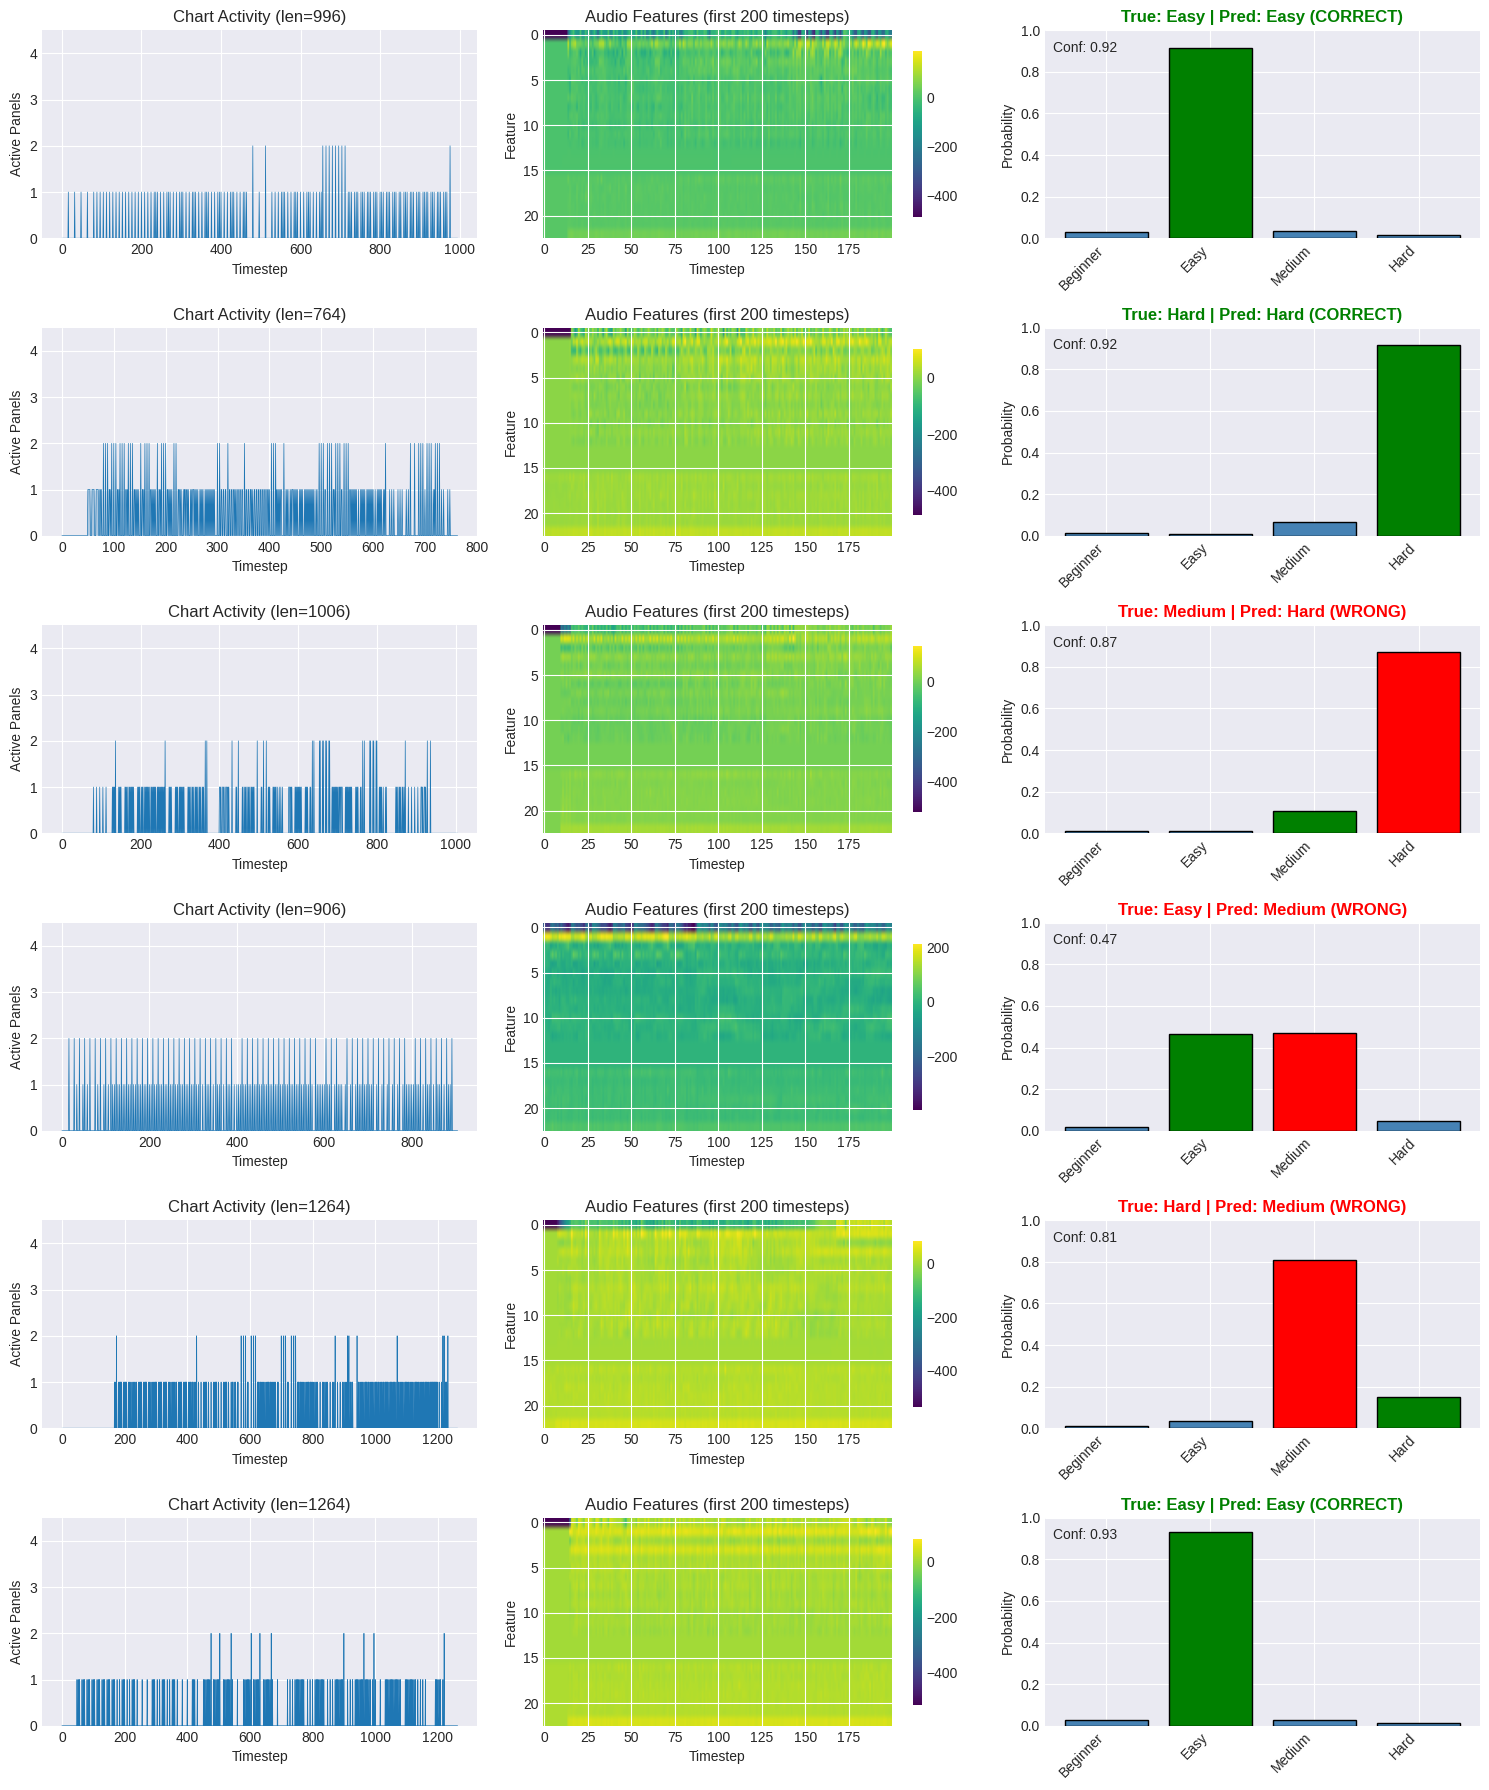

In [6]:
# Get a random batch and visualize
import random

def get_random_batch():
    """Get a random batch from the test loader."""
    batch_idx = random.randint(0, len(test_loader) - 1)
    for i, batch in enumerate(test_loader):
        if i == batch_idx:
            return batch
    return next(iter(test_loader))

# Run inference on random batch
batch = get_random_batch()

with torch.no_grad():
    audio = batch['audio'].to(device)
    chart = batch['chart'].to(device)
    mask = batch['mask'].to(device)
    chart_stats = batch.get('chart_stats', None)
    if chart_stats is not None:
        chart_stats = chart_stats.to(device)
    
    outputs = model(audio, chart, mask, chart_stats=chart_stats)
    # For 2-head model: outputs is dict with 'difficulty' and 'source' keys
    difficulty_logits = outputs['difficulty']
    source_logits = outputs['source']
    
    probabilities = F.softmax(difficulty_logits, dim=1)
    predictions = model.predict_class_from_logits(outputs, task='difficulty')
    source_preds = model.predict_class_from_logits(outputs, task='source')

print(f"Batch size: {batch['chart'].shape[0]}")
print(f"Sequence length: {batch['chart'].shape[1]}")
print(f"Audio features: {batch['audio'].shape[2]}")

visualize_batch(batch, predictions, probabilities, num_samples=6)

In [7]:
# Run again to see different samples
batch = get_random_batch()

with torch.no_grad():
    audio = batch['audio'].to(device)
    chart = batch['chart'].to(device)
    mask = batch['mask'].to(device)
    chart_stats = batch.get('chart_stats', None)
    if chart_stats is not None:
        chart_stats = chart_stats.to(device)
    
    outputs = model(audio, chart, mask, chart_stats=chart_stats)
    # For 2-head model: outputs is dict with 'difficulty' and 'source' keys
    difficulty_logits = outputs['difficulty']
    source_logits = outputs['source']
    
    probabilities = F.softmax(difficulty_logits, dim=1)
    predictions = model.predict_class_from_logits(outputs, task='difficulty')
    source_preds = model.predict_class_from_logits(outputs, task='source')

visualize_batch(batch, predictions, probabilities, num_samples=6)

/home/ybx/code/stepmania-chart-generator/notebooks/../src/data/audio_features.py:165: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo_estimate = librosa.beat.tempo(
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


KeyboardInterrupt: 

## 5. Full Test Epoch Evaluation

Run evaluation on the entire test set and compute comprehensive metrics.

In [8]:
from torchmetrics.classification import (
    MulticlassAccuracy, 
    MulticlassConfusionMatrix,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score
)

def evaluate_test_set(model, test_loader, device):
    """
    Run full evaluation on test set for 2-head model.
    
    Returns:
        Dictionary with all metrics and sample-level results for both difficulty and source tasks
    """
    model.eval()
    
    # Initialize difficulty metrics
    diff_accuracy = MulticlassAccuracy(num_classes=NUM_CLASSES, average='micro').to(device)
    diff_accuracy_per_class = MulticlassAccuracy(num_classes=NUM_CLASSES, average=None).to(device)
    diff_confusion = MulticlassConfusionMatrix(num_classes=NUM_CLASSES).to(device)
    diff_precision = MulticlassPrecision(num_classes=NUM_CLASSES, average=None).to(device)
    diff_recall = MulticlassRecall(num_classes=NUM_CLASSES, average=None).to(device)
    diff_f1 = MulticlassF1Score(num_classes=NUM_CLASSES, average=None).to(device)
    
    # Initialize source metrics
    src_accuracy = MulticlassAccuracy(num_classes=NUM_SOURCES, average='micro').to(device)
    src_accuracy_per_class = MulticlassAccuracy(num_classes=NUM_SOURCES, average=None).to(device)
    src_confusion = MulticlassConfusionMatrix(num_classes=NUM_SOURCES).to(device)
    src_precision = MulticlassPrecision(num_classes=NUM_SOURCES, average=None).to(device)
    src_recall = MulticlassRecall(num_classes=NUM_SOURCES, average=None).to(device)
    src_f1 = MulticlassF1Score(num_classes=NUM_SOURCES, average=None).to(device)
    
    # Collect sample-level results
    all_diff_predictions = []
    all_diff_targets = []
    all_diff_probabilities = []
    all_diff_confidences = []
    all_diff_losses = []
    
    all_src_predictions = []
    all_src_targets = []
    all_src_probabilities = []
    all_src_confidences = []
    all_src_losses = []
    
    diff_criterion = torch.nn.CrossEntropyLoss(reduction='none')
    src_criterion = torch.nn.CrossEntropyLoss(reduction='none')
    total_diff_loss = 0.0
    total_src_loss = 0.0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating test set"):
            audio = batch['audio'].to(device)
            chart = batch['chart'].to(device)
            mask = batch['mask'].to(device)
            diff_targets = batch['difficulty'].to(device)
            src_targets = batch['source'].to(device)
            
            chart_stats = batch.get('chart_stats', None)
            if chart_stats is not None:
                chart_stats = chart_stats.to(device)
            
            # Forward pass (returns dict for 2-head model)
            outputs = model(audio, chart, mask, chart_stats=chart_stats)
            diff_logits = outputs['difficulty']
            src_logits = outputs['source']
            
            # Compute losses
            diff_losses = diff_criterion(diff_logits, diff_targets)
            src_losses = src_criterion(src_logits, src_targets)
            total_diff_loss += diff_losses.sum().item()
            total_src_loss += src_losses.sum().item()
            
            # Get difficulty predictions and probabilities
            diff_probs = F.softmax(diff_logits, dim=1)
            diff_preds = model.predict_class_from_logits(outputs, task='difficulty')
            diff_confs = diff_probs.max(dim=1).values
            
            # Get source predictions and probabilities
            src_probs = F.softmax(src_logits, dim=1)
            src_preds = model.predict_class_from_logits(outputs, task='source')
            src_confs = src_probs.max(dim=1).values
            
            # Update difficulty metrics
            diff_accuracy.update(diff_preds, diff_targets)
            diff_accuracy_per_class.update(diff_preds, diff_targets)
            diff_confusion.update(diff_preds, diff_targets)
            diff_precision.update(diff_preds, diff_targets)
            diff_recall.update(diff_preds, diff_targets)
            diff_f1.update(diff_preds, diff_targets)
            
            # Update source metrics
            src_accuracy.update(src_preds, src_targets)
            src_accuracy_per_class.update(src_preds, src_targets)
            src_confusion.update(src_preds, src_targets)
            src_precision.update(src_preds, src_targets)
            src_recall.update(src_preds, src_targets)
            src_f1.update(src_preds, src_targets)
            
            # Store sample-level results
            all_diff_predictions.extend(diff_preds.cpu().numpy())
            all_diff_targets.extend(diff_targets.cpu().numpy())
            all_diff_probabilities.extend(diff_probs.cpu().numpy())
            all_diff_confidences.extend(diff_confs.cpu().numpy())
            all_diff_losses.extend(diff_losses.cpu().numpy())
            
            all_src_predictions.extend(src_preds.cpu().numpy())
            all_src_targets.extend(src_targets.cpu().numpy())
            all_src_probabilities.extend(src_probs.cpu().numpy())
            all_src_confidences.extend(src_confs.cpu().numpy())
            all_src_losses.extend(src_losses.cpu().numpy())
    
    # Compute final results
    n_samples = len(test_loader.dataset)
    results = {
        # Difficulty task results
        'accuracy': diff_accuracy.compute().item(),
        'accuracy_per_class': diff_accuracy_per_class.compute().cpu().numpy(),
        'confusion_matrix': diff_confusion.compute().cpu().numpy(),
        'precision': diff_precision.compute().cpu().numpy(),
        'recall': diff_recall.compute().cpu().numpy(),
        'f1': diff_f1.compute().cpu().numpy(),
        'avg_loss': total_diff_loss / n_samples,
        'predictions': np.array(all_diff_predictions),
        'targets': np.array(all_diff_targets),
        'probabilities': np.array(all_diff_probabilities),
        'confidences': np.array(all_diff_confidences),
        'losses': np.array(all_diff_losses),
        
        # Source task results
        'source_accuracy': src_accuracy.compute().item(),
        'source_accuracy_per_class': src_accuracy_per_class.compute().cpu().numpy(),
        'source_confusion_matrix': src_confusion.compute().cpu().numpy(),
        'source_precision': src_precision.compute().cpu().numpy(),
        'source_recall': src_recall.compute().cpu().numpy(),
        'source_f1': src_f1.compute().cpu().numpy(),
        'source_avg_loss': total_src_loss / n_samples,
        'source_predictions': np.array(all_src_predictions),
        'source_targets': np.array(all_src_targets),
        'source_probabilities': np.array(all_src_probabilities),
        'source_confidences': np.array(all_src_confidences),
        'source_losses': np.array(all_src_losses),
    }
    
    return results

# Run evaluation
results = evaluate_test_set(model, test_loader, device)

print("\n" + "="*60)
print("TEST SET RESULTS (2-HEAD MODEL)")
print("="*60)
print(f"Total samples: {len(results['predictions'])}")
print(f"\n--- Difficulty Task ---")
print(f"Average loss: {results['avg_loss']:.4f}")
print(f"Accuracy: {results['accuracy']:.4f} ({results['accuracy']*100:.1f}%)")
print(f"\n--- Source Task ---")
print(f"Average loss: {results['source_avg_loss']:.4f}")
print(f"Accuracy: {results['source_accuracy']:.4f} ({results['source_accuracy']*100:.1f}%)")

Evaluating test set:   0%|                                | 0/3 [00:00<?, ?it/s]/home/ybx/code/stepmania-chart-generator/notebooks/../src/data/audio_features.py:165: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo_estimate = librosa.beat.tempo(
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
Evaluat


TEST SET RESULTS (2-HEAD MODEL)
Total samples: 609

--- Difficulty Task ---
Average loss: 0.7178
Accuracy: 0.7767 (77.7%)

--- Source Task ---
Average loss: 0.7398
Accuracy: 0.4433 (44.3%)


## 6. Confusion Matrix

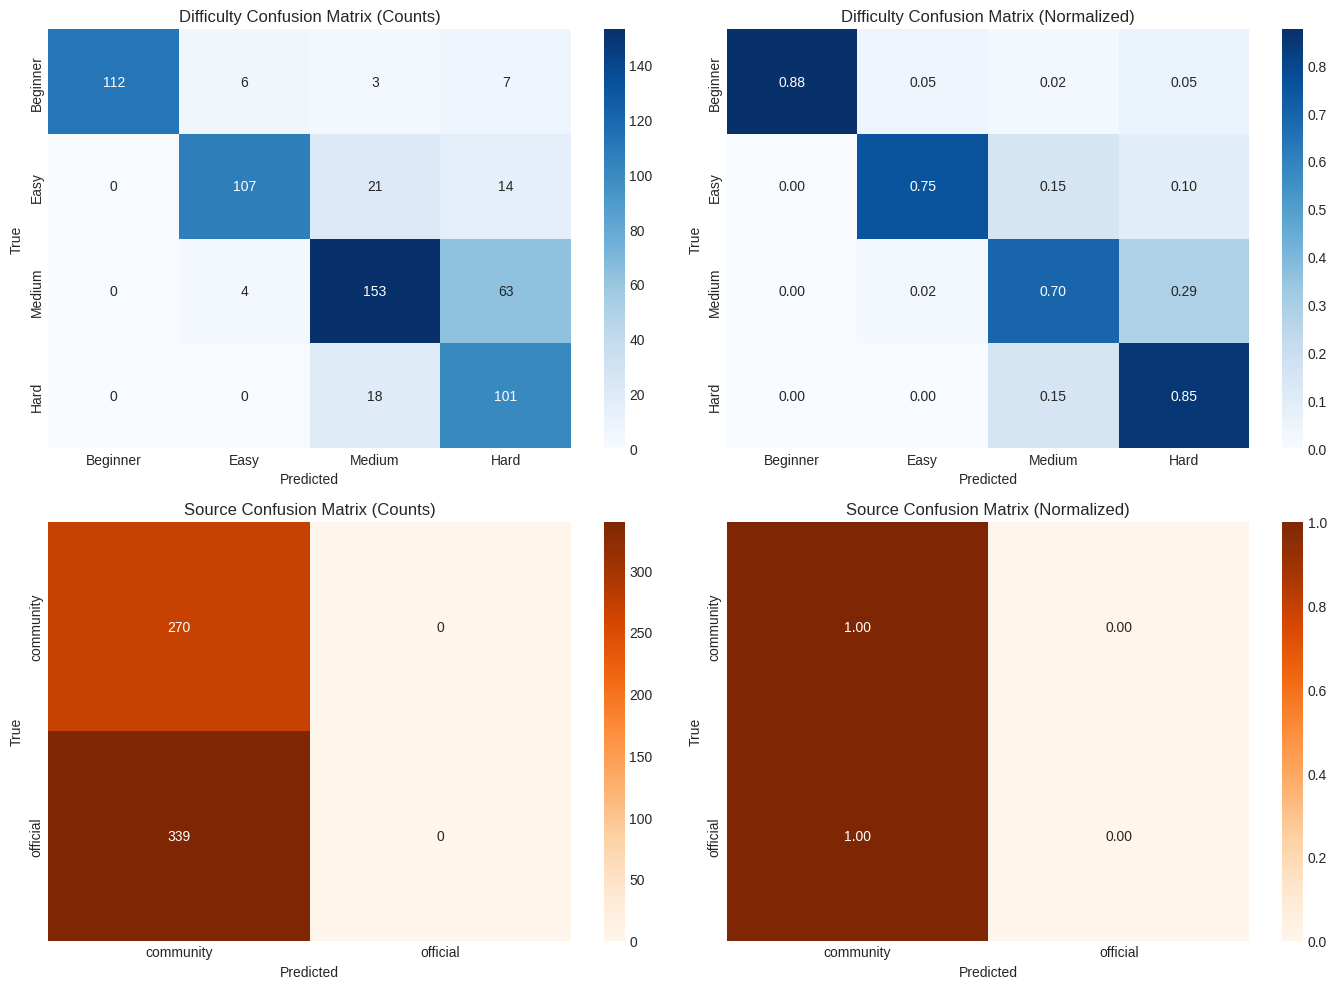

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ===== Difficulty Confusion Matrices (Top Row) =====
# Raw confusion matrix
ax = axes[0, 0]
cm = results['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=DIFFICULTY_NAMES, yticklabels=DIFFICULTY_NAMES, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Difficulty Confusion Matrix (Counts)')

# Normalized confusion matrix
ax = axes[0, 1]
row_sums = cm.sum(axis=1, keepdims=True)
cm_normalized = np.divide(cm.astype('float'), row_sums, 
                          where=row_sums!=0, out=np.zeros_like(cm, dtype=float))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=DIFFICULTY_NAMES, yticklabels=DIFFICULTY_NAMES, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Difficulty Confusion Matrix (Normalized)')

# ===== Source Confusion Matrices (Bottom Row) =====
# Raw confusion matrix
ax = axes[1, 0]
src_cm = results['source_confusion_matrix']
sns.heatmap(src_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=SOURCE_NAMES, yticklabels=SOURCE_NAMES, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Source Confusion Matrix (Counts)')

# Normalized confusion matrix
ax = axes[1, 1]
src_row_sums = src_cm.sum(axis=1, keepdims=True)
src_cm_normalized = np.divide(src_cm.astype('float'), src_row_sums, 
                               where=src_row_sums!=0, out=np.zeros_like(src_cm, dtype=float))
sns.heatmap(src_cm_normalized, annot=True, fmt='.2f', cmap='Oranges',
            xticklabels=SOURCE_NAMES, yticklabels=SOURCE_NAMES, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Source Confusion Matrix (Normalized)')

plt.tight_layout()
plt.show()

## 7. Per-Class Metrics

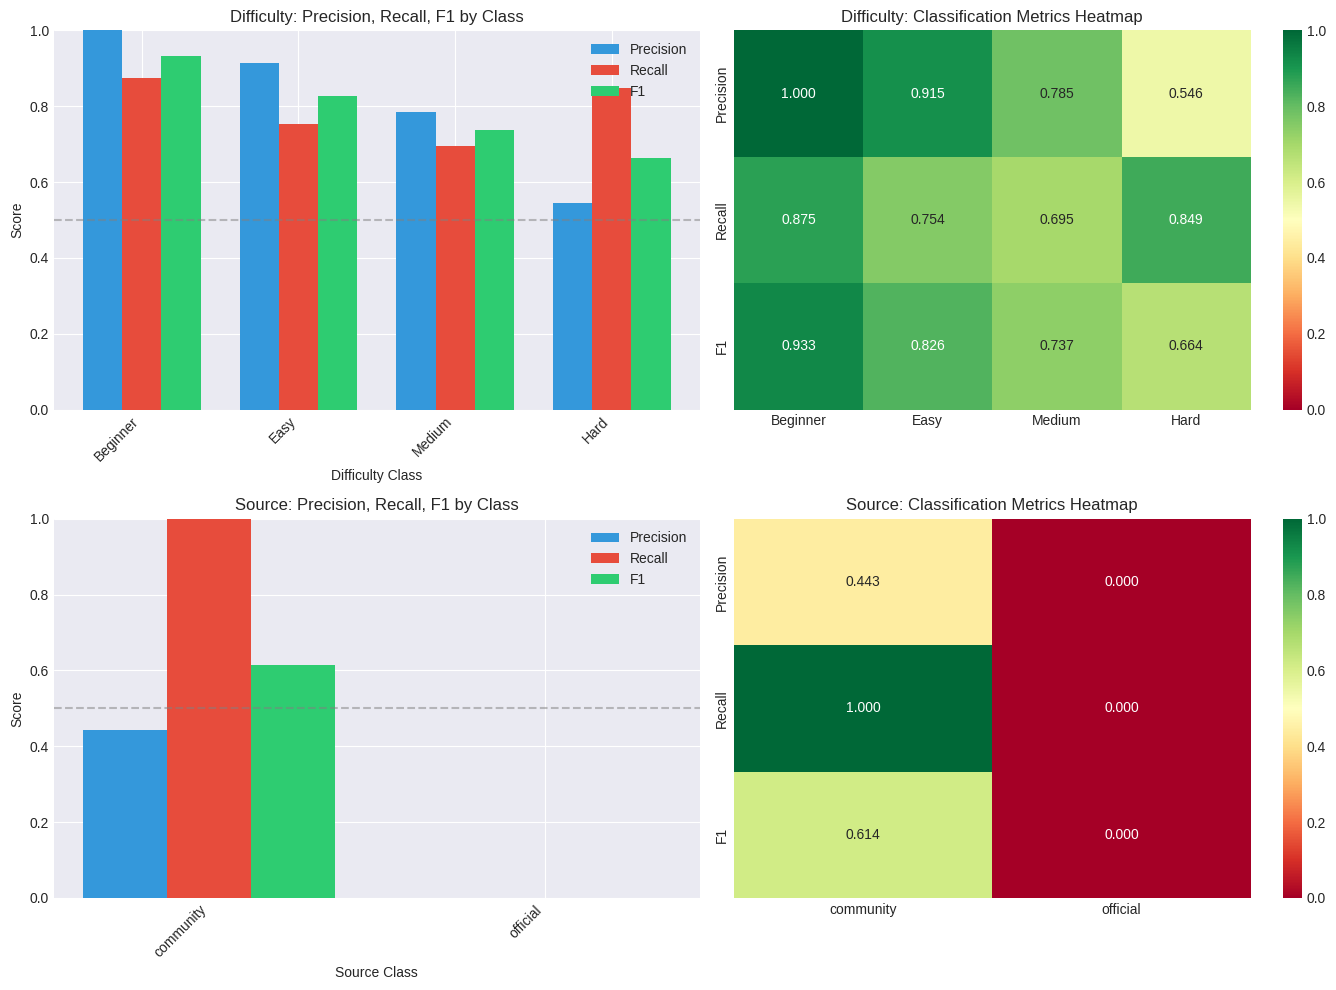


Difficulty Per-Class Classification Metrics:
----------------------------------------------------------------------
       Class  Precision     Recall         F1   Accuracy    Support
----------------------------------------------------------------------
    Beginner      1.000      0.875      0.933      0.875        128
        Easy      0.915      0.754      0.826      0.754        142
      Medium      0.785      0.695      0.737      0.695        220
        Hard      0.546      0.849      0.664      0.849        119
----------------------------------------------------------------------
   Macro Avg      0.811      0.793      0.790          -        609
    Weighted      0.814      0.777      0.785          -        609

Source Per-Class Classification Metrics:
----------------------------------------------------------------------
       Class  Precision     Recall         F1   Accuracy    Support
----------------------------------------------------------------------
   community 

In [10]:
# Create metrics visualization for both tasks
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ===== Difficulty Metrics (Top Row) =====
# Bar chart
ax = axes[0, 0]
x = np.arange(NUM_CLASSES)
width = 0.25

bars1 = ax.bar(x - width, results['precision'], width, label='Precision', color='#3498db')
bars2 = ax.bar(x, results['recall'], width, label='Recall', color='#e74c3c')
bars3 = ax.bar(x + width, results['f1'], width, label='F1', color='#2ecc71')

ax.set_xlabel('Difficulty Class')
ax.set_ylabel('Score')
ax.set_title('Difficulty: Precision, Recall, F1 by Class')
ax.set_xticks(x)
ax.set_xticklabels(DIFFICULTY_NAMES, rotation=45, ha='right')
ax.set_ylim(0, 1)
ax.legend()
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Heatmap
ax = axes[0, 1]
metrics_matrix = np.vstack([results['precision'], results['recall'], results['f1']])
sns.heatmap(metrics_matrix, annot=True, fmt='.3f', cmap='RdYlGn',
            xticklabels=DIFFICULTY_NAMES, yticklabels=['Precision', 'Recall', 'F1'],
            ax=ax, vmin=0, vmax=1, center=0.5)
ax.set_title('Difficulty: Classification Metrics Heatmap')

# ===== Source Metrics (Bottom Row) =====
# Bar chart
ax = axes[1, 0]
x = np.arange(NUM_SOURCES)
width = 0.25

bars1 = ax.bar(x - width, results['source_precision'], width, label='Precision', color='#3498db')
bars2 = ax.bar(x, results['source_recall'], width, label='Recall', color='#e74c3c')
bars3 = ax.bar(x + width, results['source_f1'], width, label='F1', color='#2ecc71')

ax.set_xlabel('Source Class')
ax.set_ylabel('Score')
ax.set_title('Source: Precision, Recall, F1 by Class')
ax.set_xticks(x)
ax.set_xticklabels(SOURCE_NAMES, rotation=45, ha='right')
ax.set_ylim(0, 1)
ax.legend()
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Heatmap
ax = axes[1, 1]
src_metrics_matrix = np.vstack([results['source_precision'], results['source_recall'], results['source_f1']])
sns.heatmap(src_metrics_matrix, annot=True, fmt='.3f', cmap='RdYlGn',
            xticklabels=SOURCE_NAMES, yticklabels=['Precision', 'Recall', 'F1'],
            ax=ax, vmin=0, vmax=1, center=0.5)
ax.set_title('Source: Classification Metrics Heatmap')

plt.tight_layout()
plt.show()

# Print detailed tables
print("\nDifficulty Per-Class Classification Metrics:")
print("-" * 70)
print(f"{'Class':>12} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Accuracy':>10} {'Support':>10}")
print("-" * 70)

support = results['confusion_matrix'].sum(axis=1)
for i in range(NUM_CLASSES):
    print(f"{DIFFICULTY_NAMES[i]:>12} {results['precision'][i]:>10.3f} {results['recall'][i]:>10.3f} "
          f"{results['f1'][i]:>10.3f} {results['accuracy_per_class'][i]:>10.3f} {int(support[i]):>10}")
print("-" * 70)

# Macro and weighted averages
macro_prec = results['precision'].mean()
macro_rec = results['recall'].mean()
macro_f1 = results['f1'].mean()

total_support = support.sum()
weighted_prec = (results['precision'] * support).sum() / total_support
weighted_rec = (results['recall'] * support).sum() / total_support
weighted_f1 = (results['f1'] * support).sum() / total_support

print(f"{'Macro Avg':>12} {macro_prec:>10.3f} {macro_rec:>10.3f} {macro_f1:>10.3f} {'-':>10} {int(total_support):>10}")
print(f"{'Weighted':>12} {weighted_prec:>10.3f} {weighted_rec:>10.3f} {weighted_f1:>10.3f} {'-':>10} {int(total_support):>10}")

print("\nSource Per-Class Classification Metrics:")
print("-" * 70)
print(f"{'Class':>12} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Accuracy':>10} {'Support':>10}")
print("-" * 70)

src_support = results['source_confusion_matrix'].sum(axis=1)
for i in range(NUM_SOURCES):
    print(f"{SOURCE_NAMES[i]:>12} {results['source_precision'][i]:>10.3f} {results['source_recall'][i]:>10.3f} "
          f"{results['source_f1'][i]:>10.3f} {results['source_accuracy_per_class'][i]:>10.3f} {int(src_support[i]):>10}")
print("-" * 70)

## 8. Error Analysis

In [ ]:
# Analyze error patterns
predictions = results['predictions']
targets = results['targets']
cm = results['confusion_matrix']

correct = (predictions == targets).sum()
total = len(predictions)

# Categorize errors by distance
adjacent_errors = 0
distant_errors = 0

for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if i == j:
            continue
        distance = abs(i - j)
        if distance == 1:
            adjacent_errors += cm[i, j]
        else:
            distant_errors += cm[i, j]

# Calculate MAE
mae = np.abs(predictions - targets).mean()

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error type pie chart
ax = axes[0]
sizes = [correct, adjacent_errors, distant_errors]
labels = ['Correct', 'Adjacent Error', 'Distant Error']
colors = ['#2ecc71', '#f1c40f', '#e74c3c']
explode = (0.05, 0, 0)
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax.set_title('Prediction Error Distribution')

# Error direction by class
ax = axes[1]
error_flow = np.zeros((NUM_CLASSES, 3))  # [under-predict, correct, over-predict]
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if j < i:
            error_flow[i, 0] += cm[i, j]  # Under-predicted (easier)
        elif j == i:
            error_flow[i, 1] += cm[i, j]  # Correct
        else:
            error_flow[i, 2] += cm[i, j]  # Over-predicted (harder)

row_sums = error_flow.sum(axis=1, keepdims=True)
error_flow_norm = np.divide(error_flow, row_sums, where=row_sums!=0, 
                            out=np.zeros_like(error_flow))

x = np.arange(NUM_CLASSES)
width = 0.25
ax.bar(x - width, error_flow_norm[:, 0], width, label='Predicted Easier', color='#3498db')
ax.bar(x, error_flow_norm[:, 1], width, label='Correct', color='#2ecc71')
ax.bar(x + width, error_flow_norm[:, 2], width, label='Predicted Harder', color='#e74c3c')
ax.set_xlabel('True Difficulty')
ax.set_ylabel('Proportion')
ax.set_title('Prediction Direction by True Class')
ax.set_xticks(x)
ax.set_xticklabels(DIFFICULTY_NAMES, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Print summary
print("\nError Analysis Summary:")
print(f"  Total samples:     {total}")
print(f"  Correct:           {correct} ({100*correct/total:.1f}%)")
print(f"  Adjacent errors:   {adjacent_errors} ({100*adjacent_errors/total:.1f}%)")
print(f"  Distant errors:    {distant_errors} ({100*distant_errors/total:.1f}%)")
print(f"\n  Mean Absolute Error: {mae:.3f}")
print(f"  (Lower is better - 0 means perfect predictions)")

## 9. Confidence Analysis

In [ ]:
confidences = results['confidences']
is_correct = (predictions == targets)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Confidence distribution
ax = axes[0]
ax.hist(confidences[is_correct], bins=30, alpha=0.7, label='Correct', color='green', density=True)
ax.hist(confidences[~is_correct], bins=30, alpha=0.7, label='Incorrect', color='red', density=True)
ax.set_xlabel('Confidence')
ax.set_ylabel('Density')
ax.set_title('Confidence Distribution')
ax.legend()

# Confidence vs accuracy (calibration)
ax = axes[1]
bins = np.linspace(0, 1, 11)
bin_indices = np.digitize(confidences, bins) - 1
bin_accuracies = []
bin_counts = []
bin_centers = []

for i in range(len(bins) - 1):
    mask = bin_indices == i
    if mask.sum() > 0:
        bin_accuracies.append(is_correct[mask].mean())
        bin_counts.append(mask.sum())
        bin_centers.append((bins[i] + bins[i+1]) / 2)

ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
ax.scatter(bin_centers, bin_accuracies, s=[c/2 for c in bin_counts], alpha=0.7, c='blue')
ax.plot(bin_centers, bin_accuracies, 'b-', alpha=0.5)
ax.set_xlabel('Mean Confidence')
ax.set_ylabel('Actual Accuracy')
ax.set_title('Calibration Plot')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()

# Confidence by class
ax = axes[2]
conf_by_class = [confidences[targets == i] for i in range(NUM_CLASSES)]
bp = ax.boxplot(conf_by_class, labels=DIFFICULTY_NAMES, patch_artist=True)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, NUM_CLASSES))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax.set_xlabel('True Difficulty')
ax.set_ylabel('Confidence')
ax.set_title('Confidence by Class')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary
print("\nConfidence Statistics:")
print(f"  Mean confidence (correct):   {confidences[is_correct].mean():.3f}")
print(f"  Mean confidence (incorrect): {confidences[~is_correct].mean():.3f}")
print(f"  Overall mean confidence:     {confidences.mean():.3f}")

## 10. Hardest and Easiest Samples

Identify samples where the model is most/least confident or has highest/lowest loss.

In [ ]:
losses = results['losses']

# Get indices sorted by loss
hardest_indices = np.argsort(losses)[::-1][:20]  # Highest loss
easiest_indices = np.argsort(losses)[:20]  # Lowest loss

print("HARDEST SAMPLES (Highest Loss):")
print("-" * 70)
print(f"{'Idx':>6} {'True':>10} {'Pred':>10} {'Conf':>8} {'Loss':>10} {'Correct':>8}")
print("-" * 70)
for idx in hardest_indices[:10]:
    true_label = DIFFICULTY_NAMES[targets[idx]]
    pred_label = DIFFICULTY_NAMES[predictions[idx]]
    conf = confidences[idx]
    loss = losses[idx]
    correct = "Yes" if is_correct[idx] else "No"
    print(f"{idx:>6} {true_label:>10} {pred_label:>10} {conf:>8.3f} {loss:>10.4f} {correct:>8}")

print("\n\nEASIEST SAMPLES (Lowest Loss):")
print("-" * 70)
print(f"{'Idx':>6} {'True':>10} {'Pred':>10} {'Conf':>8} {'Loss':>10} {'Correct':>8}")
print("-" * 70)
for idx in easiest_indices[:10]:
    true_label = DIFFICULTY_NAMES[targets[idx]]
    pred_label = DIFFICULTY_NAMES[predictions[idx]]
    conf = confidences[idx]
    loss = losses[idx]
    correct = "Yes" if is_correct[idx] else "No"
    print(f"{idx:>6} {true_label:>10} {pred_label:>10} {conf:>8.3f} {loss:>10.4f} {correct:>8}")

In [ ]:
# Visualize loss distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss distribution
ax = axes[0]
ax.hist(losses[is_correct], bins=50, alpha=0.7, label='Correct', color='green', density=True)
ax.hist(losses[~is_correct], bins=50, alpha=0.7, label='Incorrect', color='red', density=True)
ax.set_xlabel('Loss')
ax.set_ylabel('Density')
ax.set_title('Loss Distribution')
ax.legend()

# Loss by true class
ax = axes[1]
loss_by_class = [losses[targets == i] for i in range(NUM_CLASSES)]
bp = ax.boxplot(loss_by_class, labels=DIFFICULTY_NAMES, patch_artist=True)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, NUM_CLASSES))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax.set_xlabel('True Difficulty')
ax.set_ylabel('Loss')
ax.set_title('Loss by True Class')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 11. Probability Distribution Analysis

Analyze the full probability distributions for correct and incorrect predictions.

In [ ]:
probabilities = results['probabilities']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Average probability distribution for correct predictions
ax = axes[0, 0]
correct_probs = probabilities[is_correct]
mean_correct_probs = correct_probs.mean(axis=0)
ax.bar(range(NUM_CLASSES), mean_correct_probs, color='green', alpha=0.7)
ax.set_xticks(range(NUM_CLASSES))
ax.set_xticklabels(DIFFICULTY_NAMES, rotation=45, ha='right')
ax.set_ylabel('Mean Probability')
ax.set_title(f'Mean Probability Distribution (Correct, n={is_correct.sum()})')

# Average probability distribution for incorrect predictions
ax = axes[0, 1]
incorrect_probs = probabilities[~is_correct]
if len(incorrect_probs) > 0:
    mean_incorrect_probs = incorrect_probs.mean(axis=0)
    ax.bar(range(NUM_CLASSES), mean_incorrect_probs, color='red', alpha=0.7)
ax.set_xticks(range(NUM_CLASSES))
ax.set_xticklabels(DIFFICULTY_NAMES, rotation=45, ha='right')
ax.set_ylabel('Mean Probability')
ax.set_title(f'Mean Probability Distribution (Incorrect, n={(~is_correct).sum()})')

# Probability assigned to true class
ax = axes[1, 0]
true_class_probs = probabilities[np.arange(len(targets)), targets]
ax.hist(true_class_probs[is_correct], bins=30, alpha=0.7, label='Correct', color='green', density=True)
ax.hist(true_class_probs[~is_correct], bins=30, alpha=0.7, label='Incorrect', color='red', density=True)
ax.set_xlabel('Probability of True Class')
ax.set_ylabel('Density')
ax.set_title('Probability Assigned to True Class')
ax.legend()

# Entropy of predictions (uncertainty)
ax = axes[1, 1]
entropy = -np.sum(probabilities * np.log(probabilities + 1e-10), axis=1)
ax.hist(entropy[is_correct], bins=30, alpha=0.7, label='Correct', color='green', density=True)
ax.hist(entropy[~is_correct], bins=30, alpha=0.7, label='Incorrect', color='red', density=True)
ax.set_xlabel('Entropy')
ax.set_ylabel('Density')
ax.set_title('Prediction Entropy (Uncertainty)')
ax.legend()

plt.tight_layout()
plt.show()

print("\nProbability Analysis:")
print(f"  Mean prob of true class (correct):   {true_class_probs[is_correct].mean():.3f}")
print(f"  Mean prob of true class (incorrect): {true_class_probs[~is_correct].mean():.3f}")
print(f"  Mean entropy (correct):   {entropy[is_correct].mean():.3f}")
print(f"  Mean entropy (incorrect): {entropy[~is_correct].mean():.3f}")

## 12. Summary Report

In [ ]:
# Difficulty task variables
predictions = results['predictions']
targets = results['targets']
correct = (predictions == targets).sum()
total = len(predictions)

# Calculate metrics
from sklearn.metrics import f1_score
macro_f1 = f1_score(targets, predictions, average='macro')
weighted_f1 = f1_score(targets, predictions, average='weighted')
mae = np.abs(predictions - targets).mean()

# Error analysis
errors = predictions != targets
adjacent_errors = np.sum(np.abs(predictions[errors] - targets[errors]) == 1)
distant_errors = np.sum(np.abs(predictions[errors] - targets[errors]) > 1)

# Source task variables
src_predictions = results['source_predictions']
src_targets = results['source_targets']
src_correct = (src_predictions == src_targets).sum()
src_macro_f1 = f1_score(src_targets, src_predictions, average='macro')

print("="*70)
print("             TEST SET EVALUATION SUMMARY (2-HEAD MODEL)")
print("="*70)
print(f"\nModel: {CHECKPOINT_DIR.name}")
print(f"Checkpoint: {CHECKPOINT_NAME}")
print(f"Epoch: {checkpoint.get('epoch', 'N/A')}")

print(f"\n" + "-"*70)
print("DIFFICULTY TASK METRICS")
print("-"*70)
print(f"  Test samples:        {len(predictions)}")
print(f"  Average loss:        {results['avg_loss']:.4f}")
print(f"  Accuracy:            {results['accuracy']:.4f} ({results['accuracy']*100:.1f}%)")
print(f"  Macro F1:            {macro_f1:.4f}")
print(f"  Weighted F1:         {weighted_f1:.4f}")
print(f"  Mean Absolute Error: {mae:.4f}")

print(f"\n" + "-"*70)
print("DIFFICULTY PER-CLASS PERFORMANCE")
print("-"*70)
for i in range(NUM_CLASSES):
    print(f"  {DIFFICULTY_NAMES[i]:>10}: P={results['precision'][i]:.3f} R={results['recall'][i]:.3f} F1={results['f1'][i]:.3f}")

print(f"\n" + "-"*70)
print("DIFFICULTY ERROR ANALYSIS")
print("-"*70)
print(f"  Correct predictions: {correct} ({100*correct/total:.1f}%)")
print(f"  Adjacent errors:     {adjacent_errors} ({100*adjacent_errors/total:.1f}%)")
print(f"  Distant errors:      {distant_errors} ({100*distant_errors/total:.1f}%)")

# Identify problem areas
print(f"\n" + "-"*70)
print("DIFFICULTY PROBLEM AREAS")
print("-"*70)
problem_classes = np.where(results['f1'] < 0.7)[0]
if len(problem_classes) > 0:
    for c in problem_classes:
        print(f"  {DIFFICULTY_NAMES[c]}: F1={results['f1'][c]:.3f}")
        if results['recall'][c] < results['precision'][c]:
            print(f"    -> Low recall: model misses many {DIFFICULTY_NAMES[c]} samples")
        else:
            print(f"    -> Low precision: model over-predicts {DIFFICULTY_NAMES[c]}")
else:
    print("  No major problem areas (all F1 >= 0.7)")

print(f"\n" + "="*70)
print("SOURCE TASK METRICS (community vs official)")
print("="*70)
print(f"  Average loss:        {results['source_avg_loss']:.4f}")
print(f"  Accuracy:            {results['source_accuracy']:.4f} ({results['source_accuracy']*100:.1f}%)")
print(f"  Macro F1:            {src_macro_f1:.4f}")

print(f"\n" + "-"*70)
print("SOURCE PER-CLASS PERFORMANCE")
print("-"*70)
for i in range(NUM_SOURCES):
    print(f"  {SOURCE_NAMES[i]:>10}: P={results['source_precision'][i]:.3f} R={results['source_recall'][i]:.3f} F1={results['source_f1'][i]:.3f}")

print(f"\n" + "-"*70)
print("SOURCE CONFUSION MATRIX")
print("-"*70)
print(f"              Predicted")
print(f"              Community  Official")
print(f"  True Community:   {results['source_confusion_matrix'][0,0]:4d}      {results['source_confusion_matrix'][0,1]:4d}")
print(f"  True Official:    {results['source_confusion_matrix'][1,0]:4d}      {results['source_confusion_matrix'][1,1]:4d}")

print("\n" + "="*70)